In [2]:
import dwave
import dimod
import neal
import os
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridCQMSampler
from dimod import BinaryQuadraticModel, ConstrainedQuadraticModel, Binary, Integer, ExactCQMSolver, SimulatedAnnealingSampler
from neal import SimulatedAnnealingSampler
os.environ['DWAVE_API_TOKEN'] = 'DEV-02d687c5521a014df6c14e8a3ae5694cb67d5a8f'

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

from pulp import *

import sys
sys.path.append('/Users/juanfrancisco/Desktop/uc/uc-problem-annealing')
from util.utils import get_index
from util.plots import plot_schedule
from uc_annealing import UC_Annealing

# Problem definition

This notebook gives a computational representation of the Constrained Quadratic Model (CQM) for the Unit Commitment (UC) problem for a plan operator that minimises the sum of total operating expenditure of generation across generation units and a demand shortfall penalty.

**Variables**
- N: number of power plants (n = 1, ..., N)
- T: time periods (t = 1, ..., T)
- i(n,t): composite index of size NT
- x_i: binary vector of size NT indicating the state of power plant (x_00 = 0 -> off, x_00 = 1 -> on)
- C_i: vector representing the cost of operating each power plant n at time t
- D(t): demand for a time period
- E_i: vector representing the efficiency of each power plant n at time t

In [3]:
n_generators = 6
n_hours = 5
size = n_hours * n_generators

C = np.random.randint(1, 11, size= size)     # cost of power plants at different hours
E = np.random.randint(1, 11, size=size)     # efficiency of power plants at different times
D = 50   # demand for a specific time period

# Constrained Quadratic Model

In [4]:
# define a constrained quadratic model instance
cqm = ConstrainedQuadraticModel()

In [5]:
#define the variables
x = {(n, t): Binary('x{}_{}'.format(n, t)) for n in range(n_generators) for t in range(n_hours)}

In [6]:
#define the objective function
objective = BinaryQuadraticModel('BINARY')
for generator in range(n_generators):
    for hour in range(n_hours):
        index = get_index(generator, hour, n_hours)
        objective.update(C[index] * x[generator, hour])
cqm.set_objective(objective)

In [7]:
#define the contraints
sum =  BinaryQuadraticModel('BINARY')
for generator in range(n_generators):
    for hour in range(n_hours):
        index = get_index(generator, hour, n_hours)
        sum += E[index] * x[generator, hour]
cqm.add_constraint(sum >= D, label='energy_demand')

'energy_demand'

In [8]:
cqm.constraints['energy_demand'].to_polystring()

'10*x0_0 + 4*x0_1 + 3*x0_2 + 6*x0_3 + 9*x0_4 + 7*x1_0 + x1_1 + 5*x1_2 + 9*x1_3 + 5*x1_4 + 9*x2_0 + x2_1 + 9*x2_2 + 8*x2_3 + 7*x2_4 + 7*x3_0 + 7*x3_1 + 6*x3_2 + 6*x3_3 + 5*x3_4 + 8*x4_0 + 9*x4_1 + 7*x4_2 + 7*x4_3 + 6*x4_4 + 7*x5_0 + 6*x5_1 + 2*x5_2 + 10*x5_3 + 5*x5_4 >= 50.0'

In [9]:
#sample 
sampler = LeapHybridCQMSampler()
raw_sampleset = sampler.sample_cqm(cqm)
sample = raw_sampleset.first

In [10]:
feasible_sampleset = raw_sampleset.filter(lambda d: d.is_feasible)
num_feasible = len(feasible_sampleset)
if num_feasible > 0:
    best_samples = \
        feasible_sampleset.truncate(min(10, num_feasible))
else:
    best_samples = raw_sampleset.truncate(10)

print(" \n" + "=" * 30 + "BEST SAMPLE SET" + "=" * 30)
print(best_samples)

best_sample = best_samples.first.sample

 
==============================BEST SAMPLE SET==============================
  x0_0 x0_1 x0_2 x0_3 x0_4 x1_0 x1_1 x1_2 x1_3 x1_4 ... x5_4 energy num_oc. ...
0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0 ...  0.0   17.0       1 ...
1  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0 ...  0.0   17.0       1 ...
2  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0 ...  0.0   17.0       1 ...
3  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0 ...  0.0   17.0       1 ...
4  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0 ...  0.0   17.0       1 ...
5  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0 ...  0.0   17.0       1 ...
6  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0 ...  0.0   17.0       1 ...
7  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0 ...  0.0   17.0       1 ...
8  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0 ...  0.0   17.0       1 ...
9  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0 ...  0.0   17.0       1 ...
['INTEGER', 10 rows, 10 samples, 30 variab

In [11]:
filtered_keys = [key for key, value in best_sample.items() if value == 1]
completed_list = [item + '0' if len(item) == 2 else item for item in filtered_keys]
quantum_solution = [(int(item.split('_')[0][1:]), int(item.split('_')[1])) for item in completed_list]

Now we will calculate using the ExactCQMSolver

In [12]:
sampleset = ExactCQMSolver().sample_cqm(cqm)

: 

: 

# Plot results

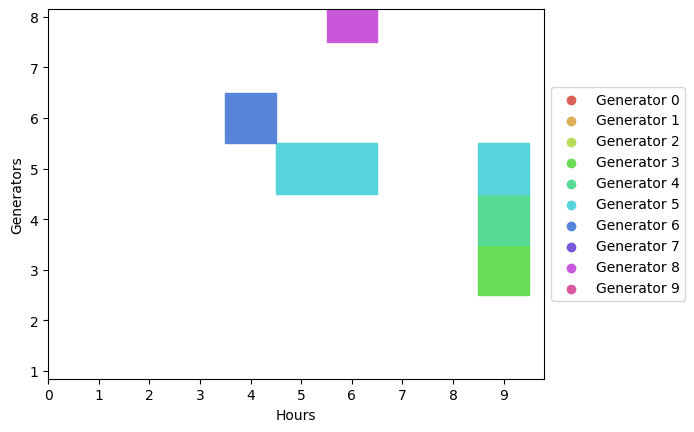

In [137]:
plot_schedule(quantum_solution, n_hours, n_generators, save_image=False, image_path=None)

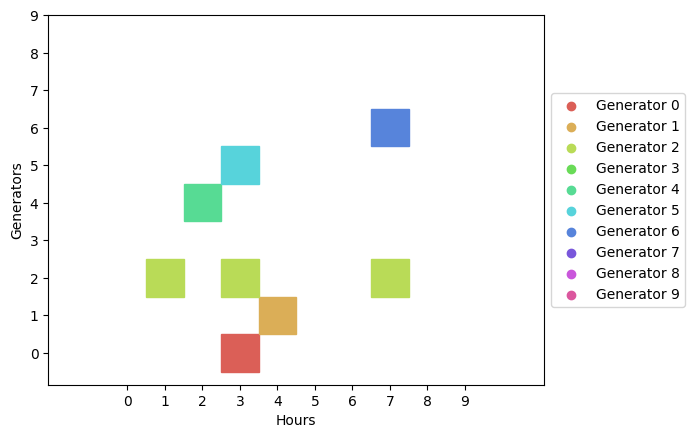

In [138]:
problem = UC_Annealing(n_generators, n_hours, C, E, D, plot = True)

# Classical implementation

In [139]:
# Create a MILP problem
prob = LpProblem("Unit_Commitment_Problem", LpMinimize)

In [140]:
# Decision variables
x = LpVariable.dicts("x", [(n, t) for n in range(n_generators) for t in range(n_hours)], cat="Binary")

In [141]:
# Objective function
prob += lpSum([C[get_index(n, t, n_hours)] * x[n, t] for n in range(n_generators) for t in range(n_hours)])

In [142]:
# Constraint function
prob += lpSum([E[get_index(n, t, n_hours)] * x[n, t] for n in range(n_generators) for t in range(n_hours)]) >= D

In [143]:
# Solve the problem
prob.solve()

# Check the solution status
if LpStatus[prob.status] == 'Optimal':
    # Retrieve the optimal solution
    solution = {(n, t): value(x[n, t]) for n in range(n_generators) for t in range(n_hours)}
    total_cost = value(prob.objective)

else:
    print("No feasible solution found.")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/juanfrancisco/Desktop/uc/uc-problem-annealing/env/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/vy/v_4tg6t57js6cy8llt2tqdh80000gn/T/59d5d8cdede246ab9ae22f20ba1dd83f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/vy/v_4tg6t57js6cy8llt2tqdh80000gn/T/59d5d8cdede246ab9ae22f20ba1dd83f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 407 RHS
At line 409 BOUNDS
At line 510 ENDATA
Problem MODEL has 1 rows, 100 columns and 100 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8 - 0.00 seconds
Cgl0004I processed model has 1 rows, 89 columns (89 integer (78 of which binary)) and 89 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.5
Cbc0038I Solution found of 9
Cbc

In [144]:
classical_solution = [(n, t) for (n, t), value in solution.items() if value == 1.0]

In [145]:
classical_solution

[(0, 3), (2, 1), (2, 3), (2, 7), (2, 9), (4, 2), (5, 3)]

In [146]:
quantum_solution

[(3, 9), (4, 9), (5, 5), (5, 6), (5, 9), (6, 4), (8, 6)]

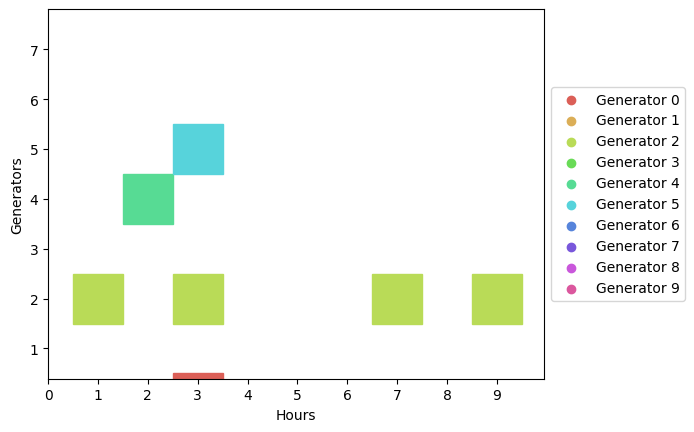

In [147]:
plot_schedule(classical_solution, n_hours, n_generators, save_image=False, image_path=None)